# ORIE 5530 Final Project

### By Yeri Chang(yc2635) and Chenyang Yan(cy477)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.linalg import eig 
from scipy.stats import poisson
import matplotlib.pyplot as plt

## Part 1

### （1）

In [2]:
states = [i for i in range(-30,51)]
tpm = np.zeros((len(states),len(states)))
for i in range(-30,51):
    for j in range(-30,51):
        if(50+i-j<0):
            tpm[i+30,j+30] = 0
        elif(i<0):
            tpm[i+30,j+30] = np.exp(-10) * 10 ** (50+i-j) / math.factorial(50+i-j)
        else:
            tpm[i+30,j+30] = np.exp(-10) * 10 ** (50-j) / math.factorial(50-j)
print("The transition probability matrix is ")
print(tpm)

The transition probability matrix is 
[[1.49272673e-19 7.46363363e-19 3.65718048e-18 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.92691515e-20 1.49272673e-19 7.46363363e-19 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.62868298e-21 2.92691515e-20 1.49272673e-19 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [6.34347830e-44 5.07478264e-43 4.00907828e-42 ... 2.26999649e-03
  4.53999298e-04 4.53999298e-05]
 [6.34347830e-44 5.07478264e-43 4.00907828e-42 ... 2.26999649e-03
  4.53999298e-04 4.53999298e-05]
 [6.34347830e-44 5.07478264e-43 4.00907828e-42 ... 2.26999649e-03
  4.53999298e-04 4.53999298e-05]]


### （2）

In [3]:
eigenvalues, eigenvectors = np.linalg.eig(tpm.T)
evec = eigenvectors[:,np.isclose(eigenvalues, 1)]
evec = evec[:,0]
stationary = evec / evec.sum()
#eigs finds complex eigenvalues and eigenvectors, we only need the real one.
stationary = stationary.real
print("The stationary distribution is ")
print(stationary)

The stationary distribution is 
[-9.83724298e-42  6.99770012e-43  1.08810208e-40  3.16259480e-41
  2.42471905e-40  1.83714878e-39  1.37556789e-38  1.01686572e-37
  7.41964979e-37  5.34049617e-36  3.79116962e-35  2.65347851e-34
  1.83078130e-33  1.24488058e-32  8.34051195e-32  5.50466852e-31
  3.57801697e-30  2.28991970e-29  1.44264617e-28  8.94439380e-28
  5.45607835e-27  3.27364597e-26  1.93145081e-25  1.12024140e-24
  6.38537573e-24  3.57581034e-23  1.96669567e-22  1.06201566e-21
  5.62868299e-21  2.92691515e-20  1.49272673e-19  7.46363363e-19
  3.65718048e-18  1.75544663e-17  8.25059916e-17  3.79527561e-16
  1.70787403e-15  7.51464571e-15  3.23129766e-14  1.35714502e-13
  5.56429457e-13  2.22571783e-12  8.68029952e-12  3.29851382e-11
  1.22045011e-10  4.39362041e-10  1.53776714e-09  5.22840828e-09
  1.72537473e-08  5.52119915e-08  1.71157174e-07  5.13471521e-07
  1.48906741e-06  4.16938875e-06  1.12573496e-05  2.92691090e-05
  7.31727725e-05  1.75614654e-04  4.03913704e-04  8.886101

#### a. long run average

In [4]:
# long run average
average = np.dot(states,stationary)
print("The long run average is " + str(average))

The long run average is 40.0


#### b. fraction of days where some customers are backlogged

In [5]:
# fraction of days
fraction = 0
for i in range(30):
    fraction = fraction + stationary[i]
print("The fraction of days where customers are backlogged is "+ str(fraction))

The fraction of days where customers are backlogged is 3.6200015838577544e-20


## Part 2

### (1) Bellman equations
>$ V(s) = max (r(x,s) + 0.9\sum P_{xy}V(y))$

> \begin{gather}
    V(s)=
    \begin{cases}
      max (-(orders \times c + |state| \times h) + 0.9 \sum P(s'|s,orders) * V(s')), & \text{if state>=0}  \\
      max (-(orders \times c + |state| \times b) + 0.9 \sum P(s'|s,orders) * V(s')), & \text{if state<0}
    \end{cases} \\
\end{gather}


### (2)

In [11]:
def reward(state, orders, c, b, h):
    return -(orders * c + h * state * int(state>=0)  - b * state * int(state<0))

def demand_p(demand):
    return np.exp(-10) * 10 ** (demand) / math.factorial(demand)

def value_iteration(lamda,c,b,h):
    discount = 0.9
    max_iter = 10
    Vs = [np.zeros(131)]
    pis = []   
    for i in range(max_iter):
        Vpre = Vs[-1]
        V = np.zeros(131)
        pi = np.zeros(131)
        for state in range(-30,101):
            maxv = -1000000
            for orders in range(101 - state):
                v = 0
                tpm = get_partial_tpm(state, orders, lamda)
                v = reward(state,orders,c,b,h) + discount * np.dot(tpm, Vpre)
                if v > maxv:
                    maxv = v
                    pi[state + 30] = orders
            V[state + 30] = maxv
        Vs.append(V)
        pis.append(pi)
    return Vs[-1], pis[-1]

def get_partial_tpm(state, orders, lamda):
    partial_tpm = np.zeros(131)
    for demand in range(state + orders + 30):
        partial_tpm[state + orders + 30 - demand] = np.exp(-lamda) * lamda ** (demand) / math.factorial(demand)
    partial_tpm[0] = 1 - sum(partial_tpm)
    return partial_tpm


### (3)

### i) b = 10, h = 2

In [38]:
value, optimal_strategy = value_iteration(15,1,10,2)

In [39]:
print("The optimal value at time 0 with 20 units in inventory is " + str(value[20 + 30]))

The optimal value at time 0 with 20 units in inventory is -182.44206846511105


In [40]:
v_order_up_to = [] 
for i in range(-30,101):
    v_order_up_to.append(i + optimal_strategy[i + 30])
print(v_order_up_to)

[19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0]


The optimal strategy in each states is


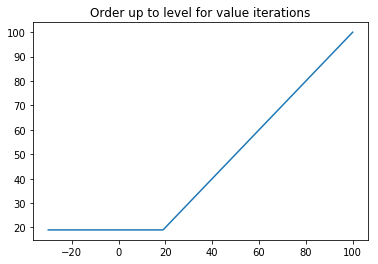

In [41]:
print("The optimal strategy in each states is")
states = [i for i in range(-30,101)]
plt.title("Order up to level for value iterations")
plt.plot(states,v_order_up_to)

We find that the optimal strategy is when inventories are below 19, order up to 19, when the inventories are above 19, order nothing, for b = 10, h = 2

### ii) b = 10, h = 5

In [42]:
value, optimal_strategy = value_iteration(15,1,10,5)

In [43]:
print("The optimal value at time 0 with 20 units in inventory is " + str(value[20 + 30]))

The optimal value at time 0 with 20 units in inventory is -298.15739803373765


In [44]:
v_order_up_to = [] 
for i in range(-30,101):
    v_order_up_to.append(i + optimal_strategy[i + 30])
print(v_order_up_to)

[16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0]


The optimal strategy in each states is


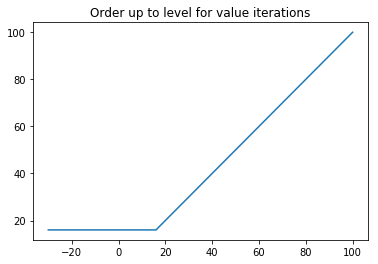

In [45]:
print("The optimal strategy in each states is")
states = [i for i in range(-30,101)]
plt.title("Order up to level for value iterations")
plt.plot(states,v_order_up_to)

We find that the optimal strategy is when inventories are below 16, order up to 16, when the inventories are above 16, order nothing, for b = 10, h = 5

### iii) b = 10, h = 10

In [46]:
value, optimal_strategy = value_iteration(15,1,10,10)

In [47]:
print("The optimal value at time 0 with 20 units in inventory is " + str(value[20 + 30]))

The optimal value at time 0 with 20 units in inventory is -462.81340319160347


In [48]:
v_order_up_to = [] 
for i in range(-30,101):
    v_order_up_to.append(i + optimal_strategy[i + 30])
print(v_order_up_to)

[15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0]


The optimal strategy in each states is


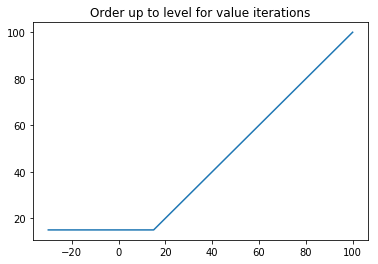

In [49]:
print("The optimal strategy in each states is")
states = [i for i in range(-30,101)]
plt.title("Order up to level for value iterations")
plt.plot(states,v_order_up_to)

We find that the optimal strategy is when inventories are below 15, order up to 15, when the inventories are above 15, order nothing, for b = 10, h = 10.

### iv) b = 5, h = 10

In [50]:
value, optimal_strategy = value_iteration(15,1,5,10)

In [51]:
print("The optimal value at time 0 with 20 units in inventory is " + str(value[20 + 30]))

The optimal value at time 0 with 20 units in inventory is -413.51768793621795


In [52]:
v_order_up_to = [] 
for i in range(-30,101):
    v_order_up_to.append(i + optimal_strategy[i + 30])
print(v_order_up_to)

[13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0]


The optimal strategy in each states is


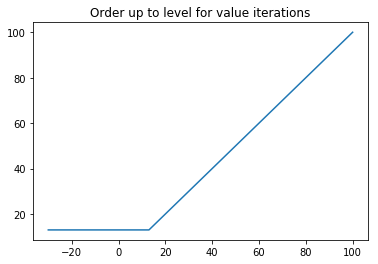

In [53]:
print("The optimal strategy in each states is")
states = [i for i in range(-30,101)]
plt.title("Order up to level for value iterations")
plt.plot(states,v_order_up_to)

We find that the optimal strategy is when inventories are below 13, order up to 13, when the inventories are above 13, order nothing, for b = 5, h = 10.

### v) b = 2, h = 10

In [54]:
value, optimal_strategy = value_iteration(15,1,2,10)

In [55]:
print("The optimal value at time 0 with 20 units in inventory is " + str(value[20 + 30]))

The optimal value at time 0 with 20 units in inventory is -366.969958310827


In [56]:
v_order_up_to = [] 
for i in range(-30,101):
    v_order_up_to.append(i + optimal_strategy[i + 30])
print(v_order_up_to)

[11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0]


The optimal strategy in each states is


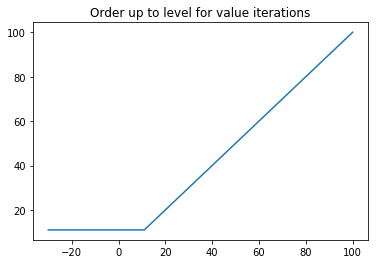

In [57]:
print("The optimal strategy in each states is")
states = [i for i in range(-30,101)]
plt.title("Order up to level for value iterations")
plt.plot(states,v_order_up_to)

We find that the optimal strategy is when inventories are below 15, order up to 15, when the inventories are above 15, order nothing, for b = 2, h = 10.

To give a more clear sense, we put the graph together, the results are below.

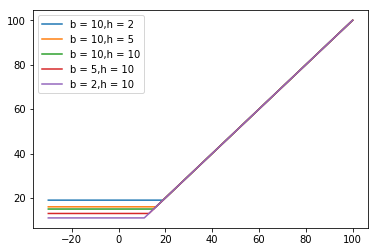

In [64]:
b = [10,10,10,5,2]
h = [2,5,10,10,10]
for i in range(5):
    optimal_strategy = value_iteration(15,1,b[i],h[i])[1]
    v_order_up_to = [] 
    for i in range(-30,101):
        v_order_up_to.append(i + optimal_strategy[i + 30])
    plt.plot(states,v_order_up_to)
plt.legend(["b = 10,h = 2","b = 10,h = 5","b = 10,h = 10","b = 5,h = 10","b = 2,h = 10"])

We can find from the graph that when the ratio of b/h decreases, the order up to level decreases as well. That make senses because when the cost of keeping backlogged decreases, we don't need to keep a high inventory as orders as well costs money.

## Part 3

### (1) and (2)

We implement the argmax function myself if order to deal with multiple same max value conditions, the function will randomly choose an index among them. 
And besides each iterations, the start state is changed to encourage explore of the whole state space. The step size is set to 1/t^0.55, the discount factor is set to 0.9 and we use epsilon greedy method the choose the action it should take, with epsilon equals to 0.2.
We also choose the start q value to be 100 to encourage the exploration of unknow state action pairs, as after experiments, the updated states q value will drop because reward is negative.

In [14]:
def reward(state, orders, c, b, h):
    return -(orders * c + h * state * int(state>=0)  - b * state * int(state<0))

def argmax(q_values):
    top = float("-inf")
    ties = []
    for i in range(len(q_values)):
        if q_values[i] > top:
            top = q_values[i]
            ties = []
        if q_values[i] == top:
            ties.append(i)
    return np.random.choice(ties)

def Q_learning(lamda,c,b,h):
    discount = 0.9
    max_iter = 100
    visting_state = []
    q_value = []
    for i in range(131):
        q_value.append([100 for j in range(131 - i)])
    epsilon = 0.2
    for runs in range(100):
        for start_states in range(-30,0):
            prev_state = start_states
            visting_state.append(prev_state)
            t = 1
            for i in range(max_iter):
                step_size = 1/t**(0.55)
                current_q = q_value[prev_state + 30][:]
                if np.random.rand() < epsilon:
                    orders = np.random.randint(len(current_q))
                else:
                    orders = argmax(current_q)
                next_state = get_next_state(prev_state, orders, lamda)
                q_value[prev_state + 30][orders] = (q_value[prev_state + 30][orders] + step_size * 
                                                    (reward(prev_state, orders, c, b, h) 
                                                     + discount * np.max(q_value[next_state + 30]) 
                                                     - q_value[prev_state + 30][orders]))
                prev_state = next_state
                t = t + 1
                visting_state.append(prev_state)
    for runs in range(10):
        for start_states in range(0,101):
            prev_state = start_states
            t = 1
            visting_state.append(prev_state)
            for i in range(max_iter):
                step_size = 1/t**(0.55)
                current_q = q_value[prev_state + 30][:]
                if np.random.rand() < epsilon:
                    orders = np.random.randint(len(current_q))
                else:
                    orders = argmax(current_q)
                next_state = get_next_state(prev_state, orders, lamda)
                q_value[prev_state + 30][orders] = (q_value[prev_state + 30][orders] + step_size * 
                                                    (reward(prev_state, orders, c, b, h) 
                                                     + discount * np.max(q_value[next_state + 30]) 
                                                     - q_value[prev_state + 30][orders]))
                prev_state = next_state
                t = t + 1
                visting_state.append(prev_state)
    return q_value,visting_state

def get_next_state(state, orders, lamda):
    partial_tpm = np.zeros(131)
    for demand in range(state + orders + 30):
        partial_tpm[state + orders + 30 - demand] = np.exp(-lamda) * lamda ** (demand) / math.factorial(demand)
    partial_tpm[0] = 1 - sum(partial_tpm)
    return np.random.choice(131,p = partial_tpm) - 30

In [ ]:
q_value,visting_state = Q_learning(15,1,10,2)

We check the frequency of visiting each states. And we found that not all states are visited as frequently as others due to the Q learning algorithm. Especially the states when the inventory is high are not always visited.

In [ ]:
for i in range(131):
    if visting_state.count(i-30) == 500:
        print("The state with inventory equals to " + str(i - 30) + " has a visit amount smaller than 500")

This part below is aiming to get rid of q value that is still 100, so that states-action part that completely not visitied will not be counted. But since we've run enough experiments, there are no such states. 
We still run this part just to make sure that if we are not running a lot of experiments, this part of algorithm can help us get rid of outliers.

In [ ]:
states = [i for i in range(-30,101)]
order_amount = []
for i in range(131):
    l = []
    for index in range(len(q_value[i])):
        if q_value[i][index] != 100:
            l.append(q_value[i][index])
    temp_array = []
    for index in np.argsort(l)[-10:]:
        temp_array.append(index)
    temp_array = np.array(temp_array)
#     if (len(temp_array) >= 10):
#         mean = np.mean(temp_array)
#         standard_deviation = np.std(temp_array)
#         distance_from_mean = abs(temp_array - mean)
#         max_deviations = 2
#         not_outlier = distance_from_mean < max_deviations * standard_deviation
#         no_outliers = temp_array[not_outlier]
#         order_amount.append(no_outliers[-1])
#     else:
    order_amount.append(temp_array[-1])

q_order_up_to = [] 
for i in range(-30,101):
    q_order_up_to.append(i + order_amount[i + 30])

In [ ]:
value, optimal_strategy = value_iteration(15,1,10,2)
v_order_up_to = [] 
for i in range(-30,101):
    v_order_up_to.append(i + optimal_strategy[i + 30])

In [ ]:
plt.scatter(states,q_order_up_to)
plt.title("Order up to level")
plt.plot(states,v_order_up_to,color = 'r')
plt.legend(["Value iteration","Q learning"])

We can find from the graph that there are some unstable jumps in the first few states, but the main trend stays the same that when inventory is below 19, bring the inventory up to 19 and when inventory is above 19, we order nothing. The Q learning converges to value iterations after enough runs.